<a href="https://colab.research.google.com/github/MrNytro/Neuron-labs-Internship/blob/main/Week4%20(Movie%20Recommendation)/Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
movies = pd.read_csv("movies.csv")

In [20]:
ratings = pd.read_csv("ratings.csv")

In [23]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307.0,3.5,1.256677e+09
1,1,481.0,3.5,1.256677e+09
2,1,1091.0,1.5,1.256677e+09
3,1,1257.0,4.5,1.256677e+09
4,1,1449.0,4.5,1.256677e+09


In [25]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,2431,2432,2433,2434,2435,2436,2437,2438,2439,2440
movieId,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,4.5,3.0,NaN,NaN,NaN,NaN,4.0
2.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,2431,2432,2433,2434,2435,2436,2437,2438,2439,2440
movieId,,,,,,,,,,,,,,,,,,,,,
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,4.5,3.0,0.0,0.0,0.0,0.0,4.0
2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

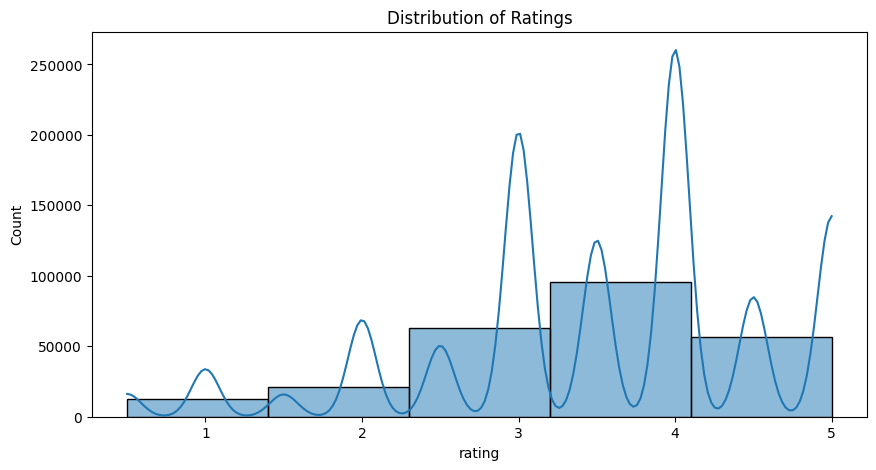

In [41]:
plt.figure(figsize=(10, 5))
sns.histplot(data=ratings, x='rating', bins=5, kde=True)
plt.title('Distribution of Ratings')
plt.show()

In [42]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [43]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [68]:
def get_movie_recommendation(movie_name):
    n_movies_to_recommend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list):
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors=n_movies_to_recommend + 1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title': movies.iloc[idx]['title'].values[0], 'Distance': val[1]})
        df = pd.DataFrame(recommend_frame, index=range(1, n_movies_to_recommend + 1))
        return df
    else:
        return "No movies found. Please check your input"


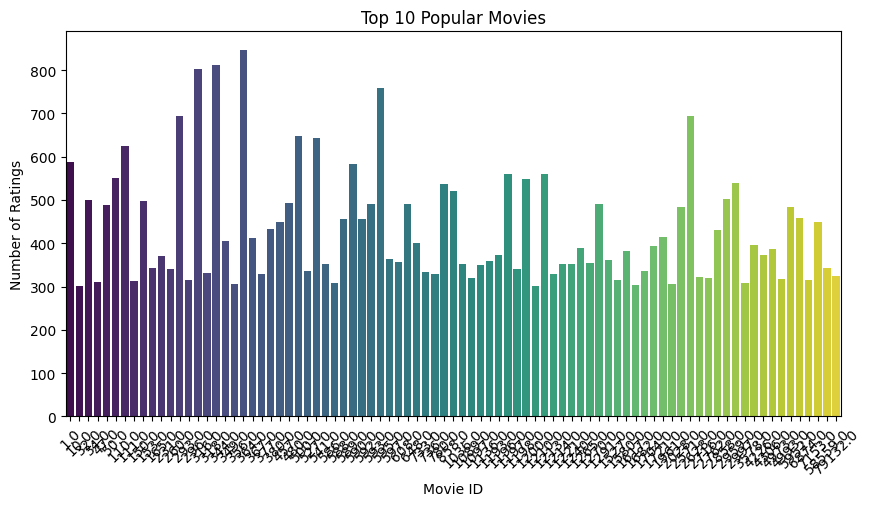

In [69]:
ratings_count = ratings['movieId'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=ratings_count[:10].index, y=ratings_count[:10].values, palette='viridis')
plt.title('Top 10 Popular Movies')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

In [70]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [71]:
get_movie_recommendation('Inception')

,Title,Distance
1,The Martian (2015),2.150493e-07
2,Black Swan (2010),2.135244e-07
3,Ex Machina (2015),2.095569e-07
4,"Avengers, The (2012)",2.088782e-07
5,Avatar (2009),2.021446e-07
6,Shutter Island (2010),1.973457e-07
7,Inglourious Basterds (2009),1.941964e-07
8,Interstellar (2014),1.891988e-07
9,"Dark Knight Rises, The (2012)",1.885049e-07
10,Django Unchained (2012),1.826858e-07
